## Reconocimiento de imagenes con CIFAR10

En esta seccion trabajaremos con un dataset muy utilizado para experimentar con reconocimiento de im ́agenes:
CIFAR10. Se trata de un conjunto de 60.000 im ́agenes RGB de 32 × 32 pixeles que contiene 10 clases de
objetos (6000 ejemplos por clase). La versi ́on utilizada se atribuye a [5] y viene separada en 50000 ejemplos
de entrenamiento y 10000 casos de prueba. El conjunto de pruebas fue obtenido seleccionando 1000 im ́
agenes
aleatorias de cada clase. Los datos restantes han sido ordenados aleatoriamente y est ́an organizados en 5
bloques de entrenamiento (batches). Las clases son mutuamente excluyentes y corresponden a las siguientes
categorıas: <b>gato, perro, rana, caballo, pajaro, ciervo, avion, automovil, camion y barco.

In [24]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.optimizers import SGD
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import StandardScaler
from scipy.misc import imread
from top_level_features import hog_features
from top_level_features import color_histogram_hsv
from top_level_features import extract_features
import matplotlib.pyplot as plt
import cPickle as pickle
import numpy as np
import os
%matplotlib inline

La data se encuentra alamcenada en diccionarios serializados de python. Por lo que se utiliza la función unpickle para deserializar dicha data.

In [3]:
def unpickle(file):
    import cPickle
    fo = open(file, 'rb')
    dict = cPickle.load(fo)
    fo.close()
    return dict

label_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog',\
'frog', 'horse', 'ship', 'truck']

Una vez extraıdo, cada diccionario contendra 2 elementos importantes: data y labels. El primer elemento
(data) es un matriz de 10000 × 3072 (numpy array). Cada fila de esa matriz corresponde a una imagen RGB:
los primeros 1024 valores vienen del canal R, los siguientes 1024 del canal G, y los últimos 1024 del canal B.
Para cada canal, las imágenes han sido vectorizadas por filas, de modo que los primeros 32 valores del canal
R corresponden a la primera fila de la imagen. Por otro lado, el elemento (labels) del diccionario contiene
una lista de 1000 valores enteros entre 0 y 9 que identifican las clases antes enumeradas.

In [42]:
def load_CIFAR_one(filename):
    with open(filename, 'rb') as f:
        datadict = pickle.load(f)
        X = datadict['data']
        Y = datadict['labels']
        return X, np.array(Y)

def load_CIFAR10(PATH):
    xs = []
    ys = []
    for b in range(1,6):
        f = os.path.join(PATH, 'data_batch_%d' % (b, ))
        X, Y = load_CIFAR_one(f)
        xs.append(X)
        ys.append(Y)
    Xtr = np.concatenate(xs)
    Ytr = np.concatenate(ys)
    trSet = np.concatenate((Xtr, Ytr.reshape(50000,1)), 1)
    np.random.shuffle(trSet)
    Xval = trSet[:10000,:3072]
    Yval = trSet[:10000,3072]
    del X, Y
    Xte, Yte = load_CIFAR_one(os.path.join(PATH, 'test_batch'))
    return Xtr, Ytr, Xte, Yte, Xval, Yval

Xtr, Ytr, Xte, Yte, Xval, Yval = load_CIFAR10('.')

## Proceso de Escala de imagenes

Se probaron dos métodos para escalar las imagenes, la primera corresponde a dividir por la intensidad maxima presente en el canal correspondiente, es decir, dividir por 255. Y la segunda corresponde a centrar y normalizar los datos.Como hemos visto a través del curso normalizar los datos es útil a la hora de entrenar modelos que son sensibles a la escala de los datos. La reducción de intensidad en estos casos tiene el efecto visual de aumentar o disminuir el brillo de la imagen. Cuando los pixeles son multiplicados por un factor menor a 1 la imagen resultante tiene menos brillo, y en el caso contrario el brillo aumenta. 

Esta técnica en general se aplica a fotografías con bajo contraste, sin embargo, se debe tener la precaución de que al escalar la imágen, los rangos de los nuevos pixeles no esten fuera de lo permitido, puesto que se pueden generar efectos indeseados en la imagen.

<img src="./imagenes/pum1dim1.gif", width="304" height="228">
<center><figcaption>Fig.1 - Imagen tomada con escasa iluminación.</figcaption></center>
<img src="./imagenes/pum1mul1.gif", width="304" height="228">
<center><figcaption>Fig.2 - Imagen obtenida escaldando cada pixel en un factor de 3.</figcaption></center>
<img src="./imagenes/pum1mul2.gif", width="304" height="228">
<center><figcaption>Fig.3 - Imagen obtenida escaldando cada pixel en un factor de 5.</figcaption></center>

In [36]:
def max_intensity_scaler(Xtr,Xt,Xval):
    Xtr_scaled = np.divide(Xtr,255.0)
    Xt_scaled = nnp.divide(Xt,255.0)
    Xval_scaled = nnp.divide(Xval,255.0)
    return Xtr_scaled, Xt_scaled, Xval

In [43]:
def scaler_function(Xtr,Xt,Xval,scale=True):
    scaler = StandardScaler(with_std=scale).fit(Xtr)
    Xtr_scaled = scaler.transform(Xtr)
    Xt_scaled = scaler.transform(Xt)
    Xval_scaled = scaler.transform(Xval)
    
    return Xtr_scaled, Xt_scaled, Xval

Xtr,Xte,Xval = scaler_function(Xtr,Xte,Xval)
Ytr = to_categorical(Ytr)
Yte = to_categorical(Yte)
Yval = to_categorical(Yval)

## Redes Neuronales

In [64]:
def history_plot(history, metrica):
    ylabel_set = {'acc': 'Accuracy',
               'val_acc': 'Accuracy',
               'loss': 'Loss',
               'val_loss': 'Loss'}
    
    title_set= {'acc': 'Accuracy Evolution Training Set',
               'val_acc': 'Accuracy Evolution Validation Set',
               'loss': 'Loss Evolution Training Set',
               'val_loss': 'Loss Evolution Validation Set'}
    color_set = ['-r.','-g.','-b.','-y.']
    label_set = ['No features','Histograma de tono','HOG','HOG+Histograma']
    plt.figure(figsize=(12, 8))
    plt.xlabel('Epochs')
    plt.ylabel(ylabel_set[metrica])
    plt.title(title_set[metrica])
    for i in range(4):
        plt.plot(range(1,51),history[i].history[metrica],color_set[i], label=label_set[i])
    plt.legend()
    plt.show()

def bars_plot(x,y):
    fig, ax = plt.subplots(figsize=(6, 4))
    width = 0.75 # the width of the bars 
    ind = np.arange(len(y))  # the x locations for the groups
    ax.barh(ind, y, width, color="blue")
    ax.set_yticks(ind+width/2)
    ax.set_yticklabels(x, minor=False)
    for i, v in enumerate(y):
        ax.text(v, i + .25, str(v), color='blue', fontweight='bold')
    plt.title('Precision de la red en los distintos sets')
    plt.xlabel('Precision')
    plt.ylabel('Set')      
    plt.show()

def scores_nn(sets):
    Xtr = sets["Xtrain"]
    Ytr = sets["Ytrain"]
    Xte = sets["Xtest"]
    Yte = sets["Ytest"]
    Xval = sets["Xvalidation"]
    Yval = sets["Yvalidation"]
    
    model = Sequential()
    model.add(Dense(100, input_dim=Xtr.shape[1], init='uniform', activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(10, init='uniform', activation='softmax'))
    model.compile(optimizer=SGD(lr=0.05), loss='binary_crossentropy', metrics=['accuracy'])
    history = model.fit(Xtr, Ytr, nb_epoch=50, batch_size=32, verbose=0, validation_data=(Xval,Yval))
    
    scores_test = model.evaluate(Xte, Yte)
    scores_validation = model.evaluate(Xval, Yval)
    scores_training = model.evaluate(Xte, Yte)
    
    accuracy = [scores_test[1],scores_validation[1],scores_training[1]]
    return accuracy, history

 9856/10000 [============================>.] - ETA: 0s

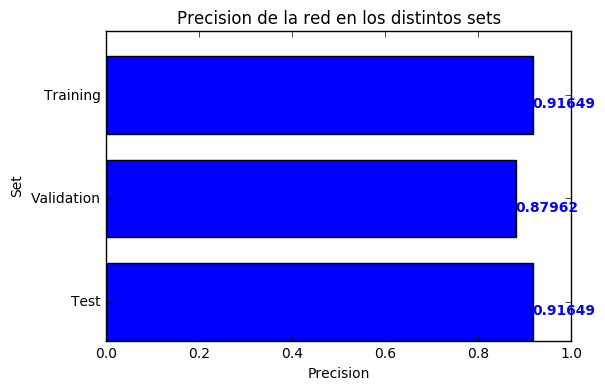

In [56]:
set = {"Xtrain":     Xtr,
       "Ytrain":     Ytr,
       "Xtest":      Xte,
       "Ytest":      Yte,
       "Xvalidation":Xval,
       "Yvalidation":Yval}
accuracy1, history1 = scores_nn(set)
labels = ["Test", "Validation", "Training"]
bars_plot(labels,accuracy1)

## Extracción de características

En esta sección se realiza el entrenamiento de la NN mediante la mejora de los atributos utilizados para representar las imagenes. Se utilizan dos tipos:

<ul>
<li><b>Histogram of oriented gradients (HOG):</b> La idea importante detrás del descriptor HOG es que la apariencia y la forma local de un objeto en una imagen pueden ser descritas por la distribución de la intensidad de gradiente o la dirección de los contornos.</li>
<li><b>Histograma de tono:</b> El histograma es una representación gráfica de la distribución de los distintos tonos de una imagen. El histograma nos ayudará a hacernos una idea de cómo es de correcta la exposición de una imagen. Así, en una fotografía subexpuesta la gráfica tenderá a desplazarse a la izquierda y en una fotografía sobreexpuesta tenderá a desplazarse a la derecha. Una imagen que contenga todos los tonos de grises tendrá un histograma más o menos uniforme a lo largo de todo el eje horizontal. </li>
</ul>

<img src="./imagenes/correcta.png", width="304" height="228">
<center><figcaption>Fig.1 - Histograma de una imagen con exposición correcta.</figcaption></center>
<img src="./imagenes/subexpuesta.png", width="304" height="228">
<center><figcaption>Fig.1 - Histograma de una imagen subexpuesta.</figcaption></center>
<img src="./imagenes/sobreexpuesta.png", width="304" height="228">
<center><figcaption>Fig.1 - Histograma de una imagen sobreexpuesta.</figcaption></center>

(50000, 32, 32, 3)
(10000, 32, 32, 3)
(10000, 32, 32, 3)
(50000, 3072)
(50000, 154)
 9600/10000 [===========================>..] - ETA: 0s

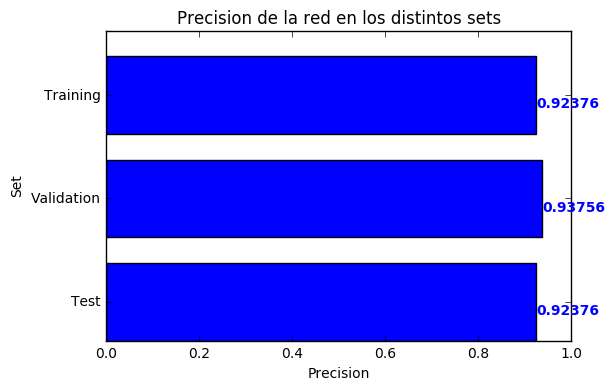

In [57]:
Xtr, Ytr, Xte, Yte, Xval, Yval = load_CIFAR10(".")
featuresHog = extract_features(Xtr,[hog_features]) #extrae hog features
featuresHogTe = extract_features(Xte,[hog_features]) #extrae hog features
featuresHogVal = extract_features(Xval,[hog_features]) #extrae hog features
Ytr = to_categorical(Ytr)
Yte = to_categorical(Yte)
Yval = to_categorical(Yval)
print Xtr.shape
print features.shape

set = {"Xtrain":     featuresHog,
       "Ytrain":     Ytr,
       "Xtest":      featuresHogTe,
       "Ytest":      Yte,
       "Xvalidation":featuresHogVal,
       "Yvalidation":Yval}
accuracy2, history2 = scores_nn(set)
bars_plot(labels,accuracy2)

(50000, 32, 32, 3)
(10000, 32, 32, 3)
(10000, 32, 32, 3)
(50000, 3072)
(50000, 154)
 9472/10000 [===========================>..] - ETA: 0s

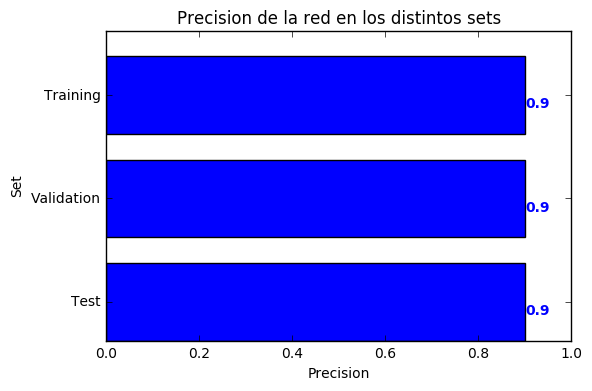

In [58]:
featuresHistg = extract_features(Xtr,[color_histogram_hsv]) #extrae hog features
featuresHistTe = extract_features(Xte,[color_histogram_hsv]) #extrae hog features
featuresHistVal = extract_features(Xval,[color_histogram_hsv]) #extrae hog features
print Xtr.shape
print features.shape

set = {"Xtrain":     featuresHist,
       "Ytrain":     Ytr,
       "Xtest":      featuresHistTe,
       "Ytest":      Yte,
       "Xvalidation":featuresHistVal,
       "Yvalidation":Yval}
accuracy3, history3 = scores_nn(set)
bars_plot(labels,accuracy3)

(50000, 32, 32, 3)
(10000, 32, 32, 3)
(10000, 32, 32, 3)
(50000, 3072)
(50000, 154)
 9728/10000 [============================>.] - ETA: 0s

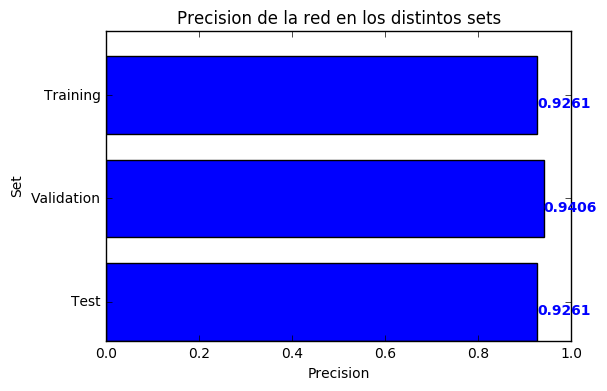

In [59]:
features = extract_features(Xtr,[hog_features, color_histogram_hsv]) #extrae hog features
featuresTe = extract_features(Xte,[hog_features, color_histogram_hsv]) #extrae hog features
featuresVal = extract_features(Xval,[hog_features, color_histogram_hsv]) #extrae hog features
print Xtr.shape
print features.shape

set = {"Xtrain":     features,
       "Ytrain":     Ytr,
       "Xtest":      featuresTe,
       "Ytest":      Yte,
       "Xvalidation":featuresVal,
       "Yvalidation":Yval}
accuracy4, history4 = scores_nn(set)
bars_plot(labels,accuracy4)

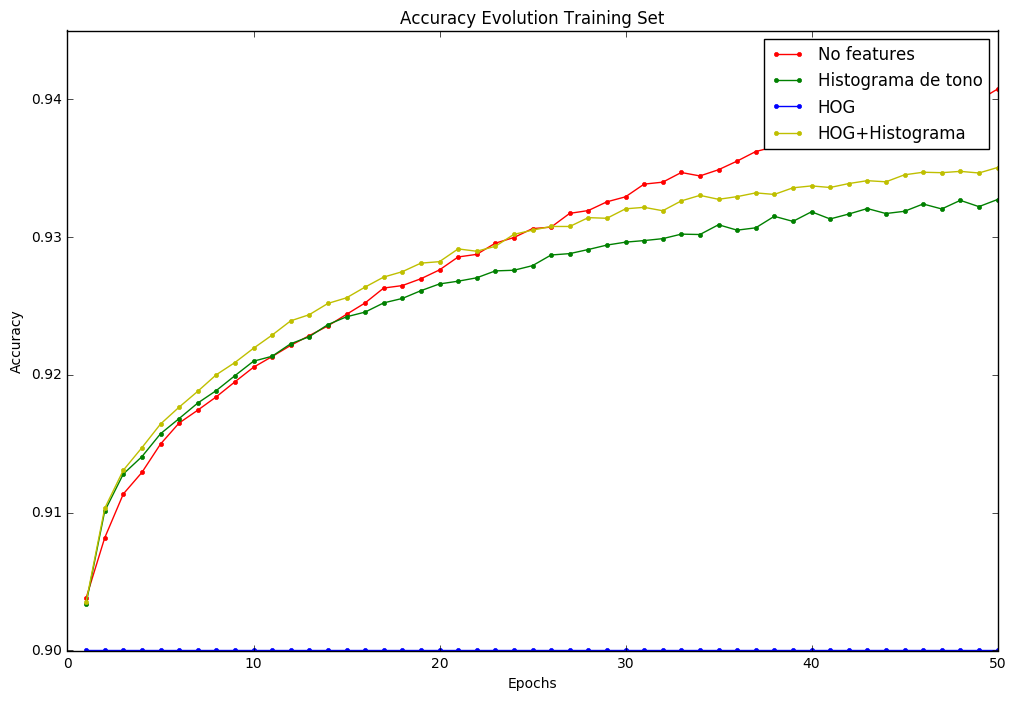

In [66]:
histories = [history1,history2,history3,history4]
history_plot(histories, 'acc')

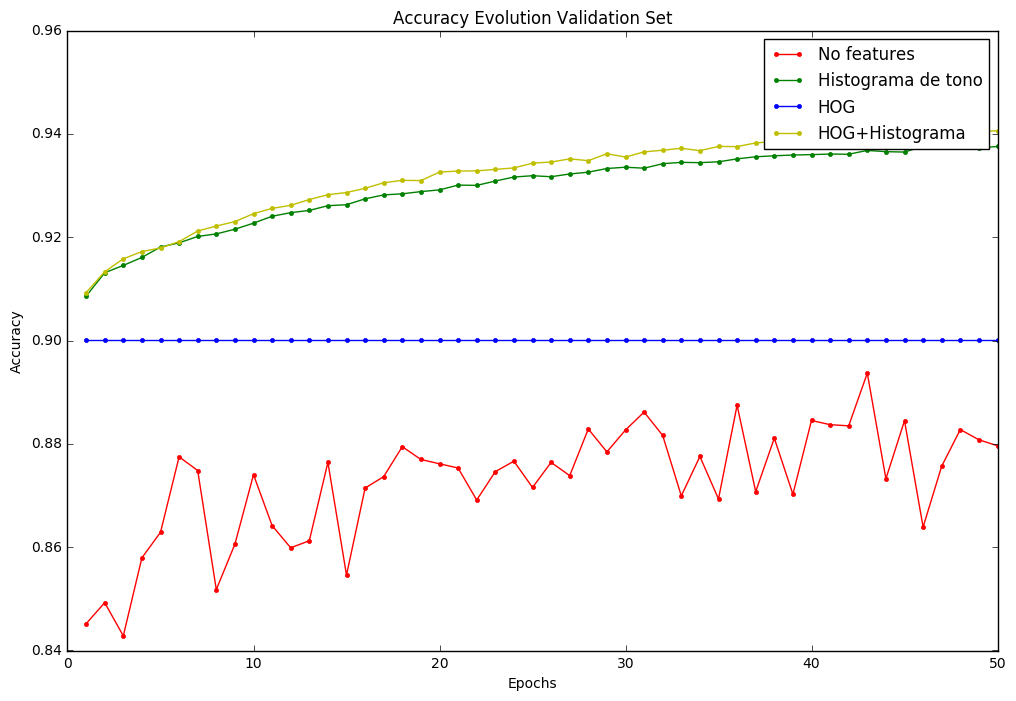

In [67]:
history_plot(histories, 'val_acc')

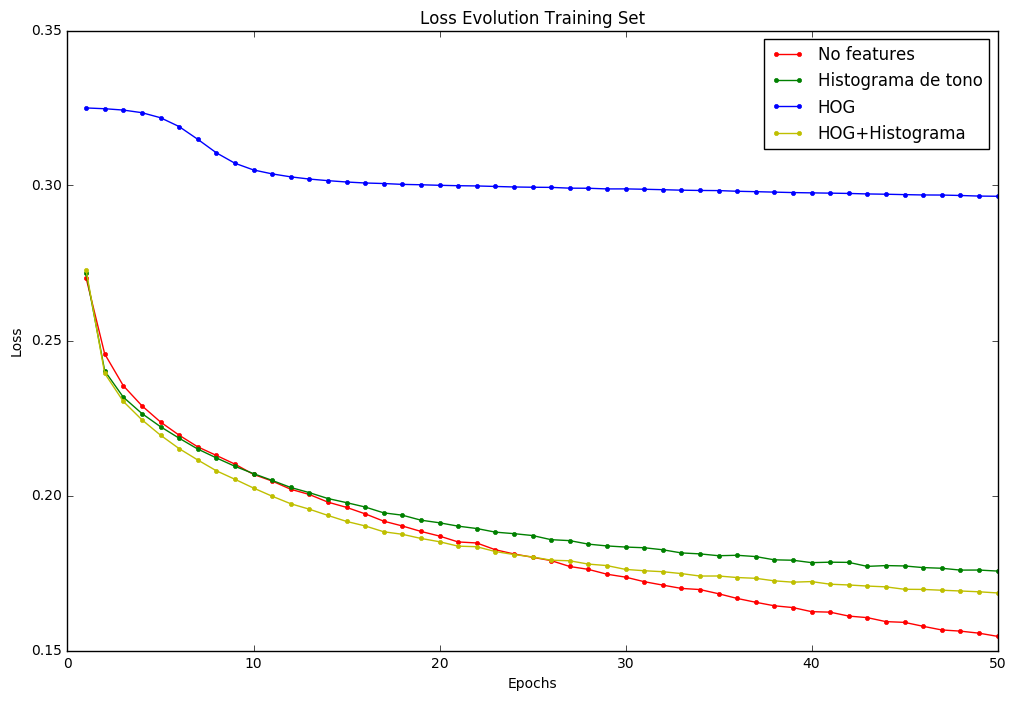

In [68]:
history_plot(histories, 'loss')

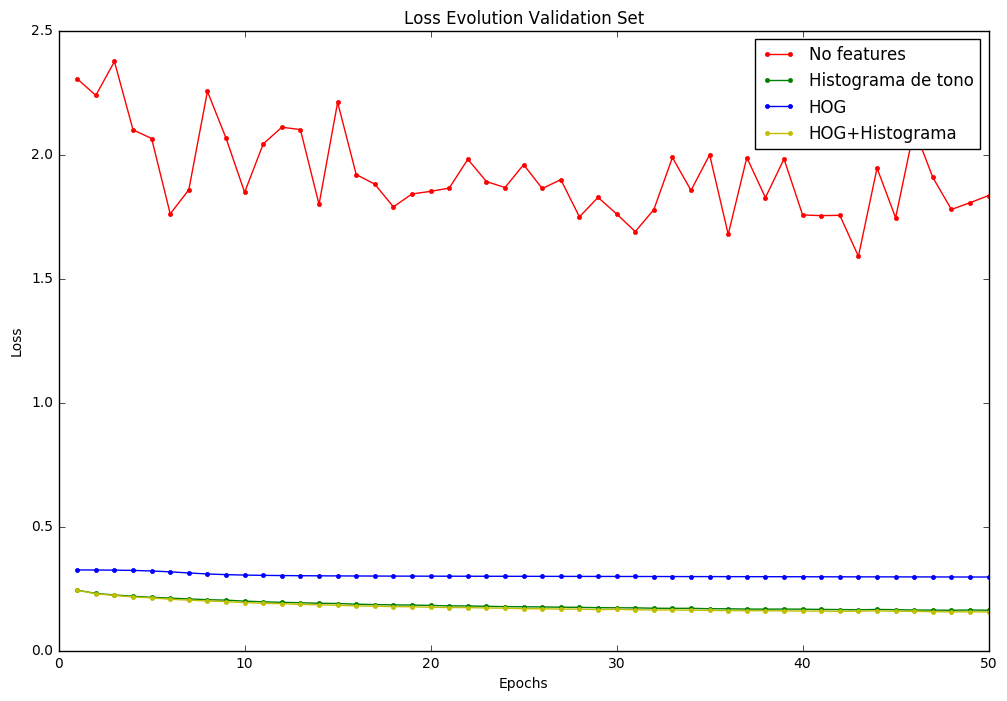

In [69]:
history_plot(histories, 'val_loss')